# Current COVID-19 Cases in Arizona by Zip Code
#### From May 5th to May 7th, 2020

The Arizona Department of Health Services (ADHS) maintains a data set of confirmed Arizona COVID-19 cases by Zip Code of the patient's residence. However, though the data set is updated once per day, no historical data is maintained and recovered cases are either not tracked or not removed from the data set. This makes the ADHS "COVID-19 Cases by Zip Code" map not practically useful for measuring current case loads by zip code.

For this reason I will retrieve the data set once per day for three days in an attempt to measure the current case loads by zip codes in Arizona. I will then agglomerate and visualize this data such that a resident could easily understand how their zip code is currently affected by COVID-19 and therefore plan their errands accordingly. For the visualizations, both the *pandas* and *geopandas* Python packages will be used.

In [1]:
import pandas as pd
import geopandas as gpd
import descartes
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import math
matplotlib.style.use('ggplot')

dayOne = pd.read_csv('COVID19CONFIRMED_BYZIP_excel.csv')
dayTwo = pd.read_csv('COVID19CONFIRMED_BYZIP_excel2.csv')
dayThree = pd.read_csv('COVID19CONFIRMED_BYZIP_excel3.csv')
ZipCities = pd.read_csv('AZZipCities.csv')
dayOne

,POSTCODE,ConfirmedCaseCategory,ConfirmedCaseCount
0,85347,0,0
1,85356,1-5,1-5
2,85365,11-25,13
3,85350,26-40,30
4,85367,1-5,1-5
...,...,...,...
380,86042,Data Suppressed,Data Suppressed
381,86030,Data Suppressed,Data Suppressed
382,86507,Data Suppressed,Data Suppressed
383,86043,Data Suppressed,Data Suppressed


    A subset of the raw data used in this report is shown above.

### **Assumptions**

For zip codes with less than ten confirmed cases, for some reason the exact case count is either not known or not reported and a range is given. For this reason, I will only consider zip codes with more than ten cases on the first day. There are also certain zip codes where the case numbers are listed as *Suppressed* by ADHS and not reported (these seem to be zip codes with very high case numbers!), which I also cannot consider. I will also consider case numbers that went down as accounting errors (which they must be) and assume no case numbers were added for those zip codes. (There should be a better way to do this part but cbf)

In [2]:
#Drop unncessary case category columns
dayOne = dayOne.drop(columns=['ConfirmedCaseCategory'],axis=1)
dayTwo = dayTwo.drop(columns=['ConfirmedCaseCategory'],axis=1)
dayThree = dayThree.drop(columns=['ConfirmedCaseCategory'],axis=1)

In [3]:
#Join days 1-3 tables
firstJoin = pd.merge(dayTwo, dayThree, on='POSTCODE',suffixes=('2','3'))
secondJoin = pd.merge(dayOne, firstJoin, on='POSTCODE')

#Join cities
dayOneToThree = pd.merge(ZipCities, secondJoin, on='POSTCODE')

#Drop cases < 10 or suppressed
for index, row in dayOneToThree.iterrows():
    if '-' in row['ConfirmedCaseCount'] or '-' in row['ConfirmedCaseCount2'] or '-' in row['ConfirmedCaseCount3']:
        dayOneToThree.drop(index, inplace=True)
    elif row['ConfirmedCaseCount'] == '0':
        dayOneToThree.drop(index, inplace=True)
    elif row['ConfirmedCaseCount'] == 'Data Suppressed':
        dayOneToThree.drop(index, inplace=True)

#Convert case numbers to ints
caseNumberColumns = ['ConfirmedCaseCount','ConfirmedCaseCount2','ConfirmedCaseCount3']
dayOneToThree[caseNumberColumns] = dayOneToThree[caseNumberColumns].astype(int)

#Add net change column
dayOneToThree['Net Change'] = dayOneToThree['ConfirmedCaseCount3'] - dayOneToThree['ConfirmedCaseCount']

#Add percentage change column
dayOneToThree['% Change'] = 100*(dayOneToThree['ConfirmedCaseCount3'] / dayOneToThree['ConfirmedCaseCount'])

#Make net change 0 if net change < 0 to fix map accuracy (must occur from misreporting)
dayOneToThree.loc[dayOneToThree['Net Change'] < 0, 'Net Change'] = 0
dayOneToThree.loc[dayOneToThree['% Change'] < 100, '% Change'] = 100

#sort
dayOneToThree = dayOneToThree.sort_values(by='% Change', ascending=False)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(dayOneToThree)

,POSTCODE,City,ConfirmedCaseCount,ConfirmedCaseCount2,ConfirmedCaseCount3,Net Change,% Change
511,86314,Prescott Valley,13,18,23,10,176.923077
284,85302,Glendale,45,59,71,26,157.777778
233,85131,Toltec,46,61,72,26,156.521739
232,85131,Eloy,46,61,72,26,156.521739
628,85363,Youngtown,21,22,31,10,147.619048
...,...,...,...,...,...,...,...
473,85016,Phoenix,55,50,53,0,100.000000
164,85629,Continental,35,35,34,0,100.000000
165,85629,Sahuarita,35,35,34,0,100.000000
460,85382,Peoria,131,129,130,0,100.000000


Above, I have joined the past three days of reported cases into one table and have added three new columns:
1. **City** : city that the zip code is located in
2. **Net Change** : cumulative number of new confirmed cases across day 2 and day 3
3. **% Change** : ratio of day1:day3 case numbers, represents growth rate

Text(0.5, 1.0, 'Top 10 Cities: Number of Cases Added')

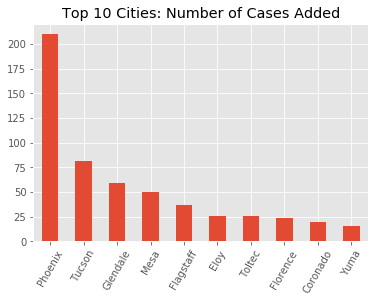

In [4]:
byCity = dayOneToThree.groupby('City').sum().reset_index()
byCity = byCity.sort_values(by='Net Change', ascending=False)

byCityTopTenPlot = byCity['Net Change'].head(10).plot.bar(rot=60)
byCityTopTenPlot.set_xticklabels(byCity.City)
byCityTopTenPlot.set_title('Top 10 Cities: Number of Cases Added')

Above, I have plotted the ten cities in AZ with the highest **Net Change** in the past 2 days.

Text(0.5, 1.0, 'Top 10 Cities: Growth Rate')

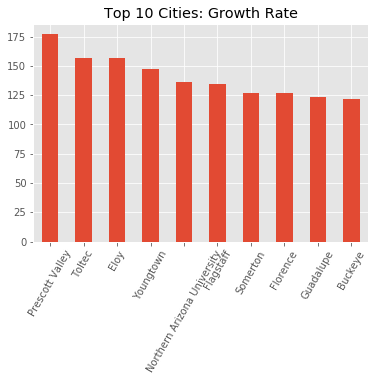

In [5]:
byCity2 = dayOneToThree.groupby('City').mean().reset_index()
byCity2 = byCity2.sort_values(by='% Change', ascending=False)

byCity2TopTenPlot = byCity2['% Change'].head(10).plot.bar(rot=60)
byCity2TopTenPlot.set_xticklabels(byCity2.City)
byCity2TopTenPlot.set_title('Top 10 Cities: Growth Rate')

Above, I have plotted the ten cities in AZ with the highest **% Change** in the past 2 days.

Based on this, it would seem as though residents of Cottonwood, AZ should exercise extreme caution.

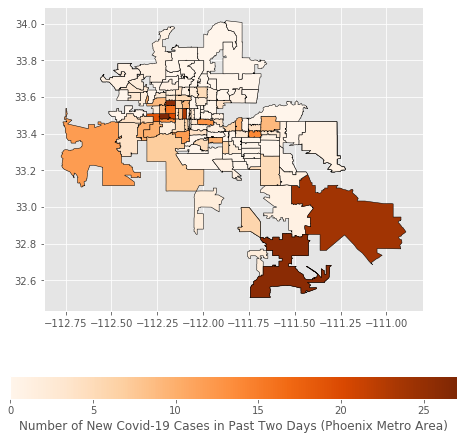

In [9]:
onlyNetChange = dayOneToThree[['POSTCODE', 'Net Change']].copy()#.rename({'POSTCODE':'Name'}, axis=1)

azMap = gpd.read_file(r'C:\Users\hi\OneDrive - Arizona State University\STP 494\Project 2\ZipsShape\Zips3.shp')
azMap['POSTCODE'] = azMap['Name'].values.astype(int)

azNetChange = azMap.merge(onlyNetChange, on='POSTCODE')
fix,ax = plt.subplots(figsize = (8,8))
azNetChange.plot(ax=ax,cmap='Oranges',
                 edgecolor='black',
                 column='Net Change',
                 legend=True,
                 legend_kwds={'label':'Number of New Covid-19 Cases in Past Two Days (Phoenix Metro Area)',
                             'orientation':'horizontal'})

Above, I have joined the **Net Change** values to a geographic map of Phoenix metro-area zip codes and applied a white-red colormap. The darker the red, the higher the **Net Change** value. Double click on the map to enlarge.

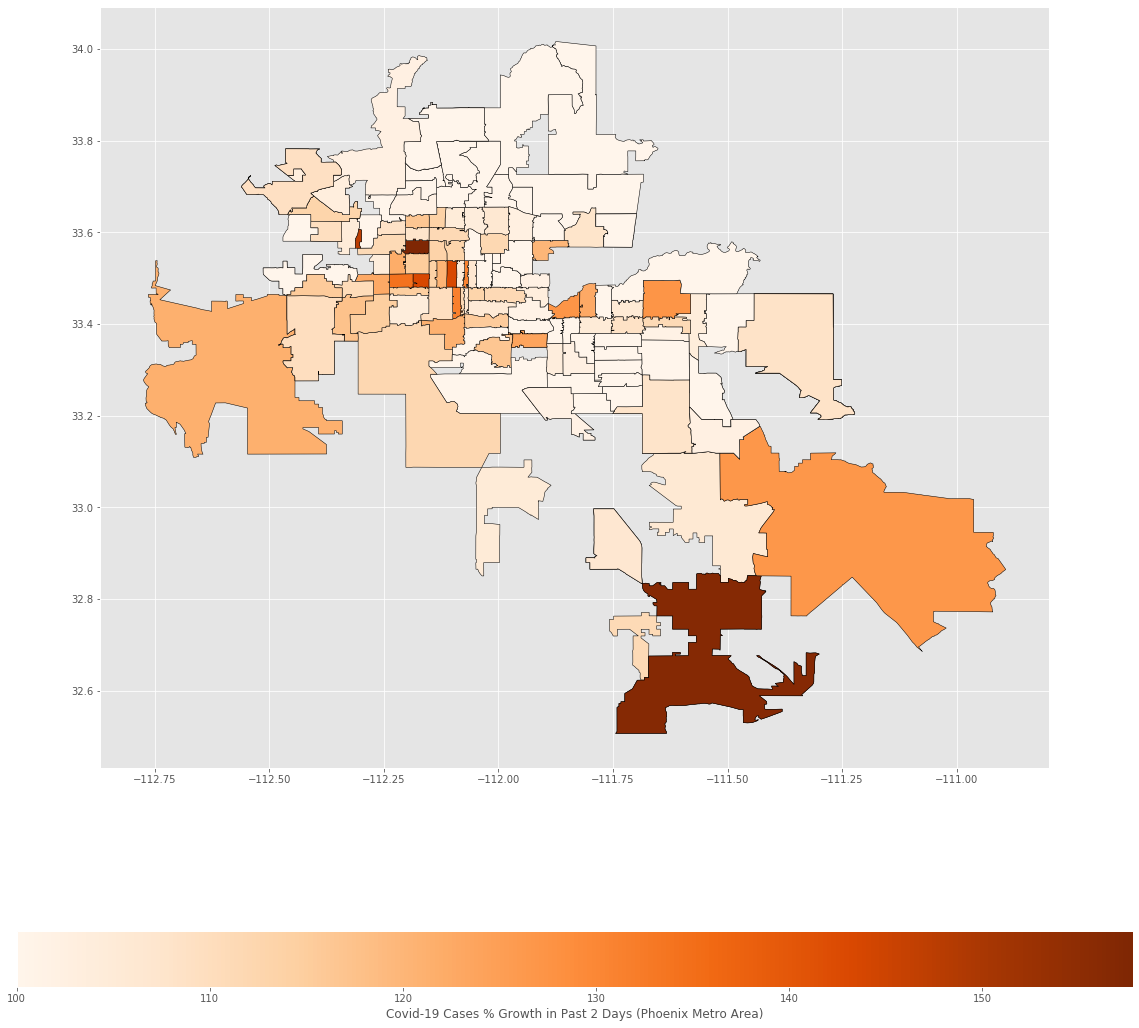

In [7]:
onlyPChange = dayOneToThree[['POSTCODE', '% Change']].copy()

azPChange = azMap.merge(onlyPChange, on='POSTCODE')
fix,ax = plt.subplots(figsize = (20,20))
azPChange.plot(ax=ax,cmap='Oranges',
                 edgecolor='black',
                 column='% Change',
                 legend=True,
                 legend_kwds={'label':'Covid-19 Cases % Growth in Past 2 Days (Phoenix Metro Area)',
                             'orientation':'horizontal'})

Above, I have joined the **% Change** values to a geographic map of Phoenix metro-area zip codes and applied a white-red colormap. The darker the red, the higher the **% Change** value. Double click on the map to enlarge.

### **Conclusion**

In summary, we have agglomerated and visualized the recently reported COVID-19 cases in Arizona. We also created two infection heat maps on a geographic map of the Phoenix metro area so that a resident of Phoenix might easily see how the state of infection in their community has changed over the past two days.

Thank you for reading! We hope you have found this helpful.

### References

Arizona COVID-19 data "CVD_ZIPS_FORWEBMAP" retrieved from:
https://services1.arcgis.com/mpVYz37anSdrK4d8/arcgis/rest/services/CVD_ZIPS_FORWEBMAP/FeatureServer

Phoenix Zip Codes Map KML file used to create .shp file. retrieved from:
https://phoenix.org/maps/zip-code-map/

Arizona Zip Codes List retrieved from:
https://data.mongabay.com/igapo/zip_codes/AZ.htm